In [58]:
!python3 -m pip install shap

from lightgbm import LGBMRegressor, early_stopping
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
import plotly
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as lgb
from optuna.samplers import TPESampler


In [59]:
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")
sub = pd.read_csv("../Data/sample_submission.csv")

In [60]:
train.head()

,ID,log_pSat_Pa,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,...,ester,ether (alicyclic),nitrate,nitro,aromatic hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester
0,0,-11.295070,224.016832,23,6,9,0,4,485.0,40.0,...,0,1,0,0,0,0,0,2,0,0
1,1,-4.782500,310.064845,35,9,10,2,1,236.0,40.0,...,0,0,2,0,0,0,0,1,0,0
2,2,-6.204319,368.033938,37,10,13,2,1,308.0,40.0,...,0,0,1,0,0,1,0,1,0,0
3,3,-9.672591,299.012475,29,7,12,1,4,769.0,3.0,...,0,0,1,0,0,0,0,1,1,0
4,4,-4.252058,202.011353,20,7,7,0,1,77.0,32.0,...,0,1,0,0,0,0,0,1,0,0


In [61]:
def create_features(df):
    df = df.copy()  # Ensure df is a copy to avoid modifying the original DataFrame
    # df.loc[:, "yksi"] = df["ketone"] / df["NumOfConfUsed"]
    df.loc[:, "kaksi"] = df["NumOfO"] / df["NumOfConf"]
    df.loc[:, "kolme"] = df["NumHBondDonors"] / df["NumOfConf"]
    # df.loc[:, "nelja"] = df["NumOfO"] / df["MW"]
    return df


# Best score was with features kaksi and kolme !!!

train = create_features(train)
test = create_features(test)


# Find categorical and continuous features
cat_features = train.select_dtypes(include="object").columns
num_features = train.select_dtypes(exclude="object").columns

num_features = num_features.drop(["log_pSat_Pa", "ID"])


In [62]:
for e in cat_features:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])
    test[e] = le.transform(test[e])


In [63]:
# Check if all column names in cat_features and num_features exist in train dataframe
cat_features = [col for col in cat_features if col in train.columns]
num_features = [col for col in num_features if col in train.columns]
# Create the data dataframe using the updated cat_features and num_features
data = train[cat_features + num_features]
target = train["log_pSat_Pa"]
data.head()

,parentspecies,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C=C (non-aromatic),...,nitro,aromatic hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,yksi,kaksi,kolme
0,6,224.016832,23,6,9,0,4,485.0,40.0,0,...,0,0,0,0,2,0,0,0.000000,0.018557,0.008247
1,0,310.064845,35,9,10,2,1,236.0,40.0,0,...,0,0,0,0,1,0,0,0.025000,0.042373,0.004237
2,0,368.033938,37,10,13,2,1,308.0,40.0,0,...,0,0,1,0,1,0,0,0.050000,0.042208,0.003247
3,6,299.012475,29,7,12,1,4,769.0,3.0,0,...,0,0,0,0,1,1,0,0.666667,0.015605,0.005202
4,6,202.011353,20,7,7,0,1,77.0,32.0,0,...,0,0,0,0,1,0,0,0.062500,0.090909,0.012987


In [64]:
def objective(trial, data=data, target=target):
    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "verbosity": -1,
        "metric": "rmse",
        "random_state": 74,
        "n_estimators": 10000,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.02, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "num_leaves": trial.suggest_int("num_leaves", 40, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "cat_smooth": trial.suggest_int("cat_smooth", 1, 100),
        "force_col_wise": True,
    }
    model = LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        callbacks=[early_stopping(stopping_rounds=100)],
    )

    preds = model.predict(test_x)

    rmse = root_mean_squared_error(test_y, preds)
    best_iteration = model.best_iteration_
    trial.set_user_attr("best_iteration", best_iteration)

    return rmse

In [65]:
db_path = "sqlite:///../Data/optuna.db"
study_name = "new_exp2"

# Create a new study or load an existing one
study = optuna.create_study(
    study_name=study_name,
    storage=db_path,
    load_if_exists=True,
    direction="minimize",
    sampler=TPESampler(seed=17),
    # sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler()
)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

trial = study.best_trial

hp_lgbm = study.best_params
hp_lgbm["n_estimators"] = study.best_trial.user_attrs["best_iteration"]

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-06 02:37:18,146] Using an existing study with name 'new_exp2' instead of creating a new one.
[I 2024-12-06 02:37:18,149] A new study created in memory with name: no-name-78000a5c-f0d9-4fd2-bfad-a82470f71768


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:24,152] Trial 0 finished with value: 1.5657761720237524 and parameters: {'reg_alpha': 0.12636751652912445, 'reg_lambda': 3.642563459317644, 'colsample_bytree': 0.7560979700594778, 'subsample': 0.7355921305619589, 'learning_rate': 0.013497680632599597, 'max_depth': 7, 'num_leaves': 99, 'min_child_samples': 44, 'cat_smooth': 2}. Best is trial 0 with value: 1.5657761720237524.


Early stopping, best iteration is:
[1227]	valid_0's rmse: 1.56578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6851]	valid_0's rmse: 1.56597


[I 2024-12-06 02:37:34,872] Trial 1 finished with value: 1.5659748489502752 and parameters: {'reg_alpha': 0.02764561629110066, 'reg_lambda': 0.0020496442727552014, 'colsample_bytree': 0.7037064987396559, 'subsample': 0.8374779307878197, 'learning_rate': 0.005202860402658337, 'max_depth': 4, 'num_leaves': 51, 'min_child_samples': 5, 'cat_smooth': 12}. Best is trial 0 with value: 1.5657761720237524.


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:37,711] Trial 2 finished with value: 1.5653589242039445 and parameters: {'reg_alpha': 0.0005713309946203014, 'reg_lambda': 3.1223121549155435, 'colsample_bytree': 0.8000688367691089, 'subsample': 0.5049779485174266, 'learning_rate': 0.019110796804505358, 'max_depth': 4, 'num_leaves': 45, 'min_child_samples': 61, 'cat_smooth': 45}. Best is trial 2 with value: 1.5653589242039445.


Early stopping, best iteration is:
[1926]	valid_0's rmse: 1.56536
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:43,300] Trial 3 finished with value: 1.567140781130926 and parameters: {'reg_alpha': 6.428834566566094, 'reg_lambda': 0.8708412947919092, 'colsample_bytree': 0.4712259343630695, 'subsample': 0.9485305159593438, 'learning_rate': 0.013977812446118343, 'max_depth': 8, 'num_leaves': 52, 'min_child_samples': 61, 'cat_smooth': 71}. Best is trial 2 with value: 1.5653589242039445.


Early stopping, best iteration is:
[1149]	valid_0's rmse: 1.56714
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:47,891] Trial 4 finished with value: 1.5644308996842498 and parameters: {'reg_alpha': 0.6759561697082009, 'reg_lambda': 0.041341567942071555, 'colsample_bytree': 0.703701007912899, 'subsample': 0.7505816545897817, 'learning_rate': 0.014012993410247317, 'max_depth': 5, 'num_leaves': 41, 'min_child_samples': 78, 'cat_smooth': 77}. Best is trial 4 with value: 1.5644308996842498.


Early stopping, best iteration is:
[2193]	valid_0's rmse: 1.56443
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:54,205] Trial 5 finished with value: 1.5644307821350714 and parameters: {'reg_alpha': 1.0054433031487535, 'reg_lambda': 0.05624184004981906, 'colsample_bytree': 0.5407256686129088, 'subsample': 0.7652795941891497, 'learning_rate': 0.009948928504714835, 'max_depth': 4, 'num_leaves': 51, 'min_child_samples': 99, 'cat_smooth': 75}. Best is trial 5 with value: 1.5644307821350714.


Early stopping, best iteration is:
[4446]	valid_0's rmse: 1.56443
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:37:57,945] Trial 6 finished with value: 1.5663036191497846 and parameters: {'reg_alpha': 0.8884728222967796, 'reg_lambda': 0.0025493736975699807, 'colsample_bytree': 0.5097403250413888, 'subsample': 0.8088129649253359, 'learning_rate': 0.018755013885605562, 'max_depth': 5, 'num_leaves': 75, 'min_child_samples': 86, 'cat_smooth': 70}. Best is trial 5 with value: 1.5644307821350714.


Early stopping, best iteration is:
[1751]	valid_0's rmse: 1.5663
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:06,714] Trial 7 finished with value: 1.5637092174924756 and parameters: {'reg_alpha': 0.00036405305596451967, 'reg_lambda': 7.311456294404658, 'colsample_bytree': 0.6812245237952003, 'subsample': 0.5591685703314395, 'learning_rate': 0.007726656281849007, 'max_depth': 6, 'num_leaves': 100, 'min_child_samples': 67, 'cat_smooth': 83}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2954]	valid_0's rmse: 1.56371
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:14,473] Trial 8 finished with value: 1.5690688000988857 and parameters: {'reg_alpha': 0.002765824340037637, 'reg_lambda': 0.0013299003125888068, 'colsample_bytree': 0.8677137438104441, 'subsample': 0.6550193470891872, 'learning_rate': 0.0066769965868765475, 'max_depth': 4, 'num_leaves': 96, 'min_child_samples': 4, 'cat_smooth': 60}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[4956]	valid_0's rmse: 1.56907
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:21,785] Trial 9 finished with value: 1.5692948126003354 and parameters: {'reg_alpha': 0.29106042444730734, 'reg_lambda': 3.154487896095856, 'colsample_bytree': 0.33485665509496426, 'subsample': 0.5477832904587021, 'learning_rate': 0.009330746342209319, 'max_depth': 4, 'num_leaves': 68, 'min_child_samples': 50, 'cat_smooth': 44}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[4948]	valid_0's rmse: 1.56929
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:30,795] Trial 10 finished with value: 1.5681040421924497 and parameters: {'reg_alpha': 0.00010161321760971871, 'reg_lambda': 0.00010301661613653175, 'colsample_bytree': 0.9845278904184782, 'subsample': 0.6143013525260915, 'learning_rate': 0.00744885560023348, 'max_depth': 6, 'num_leaves': 84, 'min_child_samples': 21, 'cat_smooth': 100}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2209]	valid_0's rmse: 1.5681
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:38,320] Trial 11 finished with value: 1.5649709956148259 and parameters: {'reg_alpha': 0.004831902828517, 'reg_lambda': 0.1376168538707839, 'colsample_bytree': 0.563246693496967, 'subsample': 0.6761932536604172, 'learning_rate': 0.009603487390091682, 'max_depth': 6, 'num_leaves': 66, 'min_child_samples': 100, 'cat_smooth': 94}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2671]	valid_0's rmse: 1.56497
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:47,802] Trial 12 finished with value: 1.566126096557357 and parameters: {'reg_alpha': 3.6962338333233795, 'reg_lambda': 0.30689436245326857, 'colsample_bytree': 0.5881970475288847, 'subsample': 0.9024227742007296, 'learning_rate': 0.007387176882745385, 'max_depth': 7, 'num_leaves': 61, 'min_child_samples': 100, 'cat_smooth': 84}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2651]	valid_0's rmse: 1.56613
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:38:54,196] Trial 13 finished with value: 1.5657695030973768 and parameters: {'reg_alpha': 0.029877686470058163, 'reg_lambda': 0.013505387479798911, 'colsample_bytree': 0.39800151264911576, 'subsample': 0.5956268849124446, 'learning_rate': 0.011540972974740773, 'max_depth': 5, 'num_leaves': 81, 'min_child_samples': 79, 'cat_smooth': 28}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[3011]	valid_0's rmse: 1.56577
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:39:06,256] Trial 14 finished with value: 1.5681579547281457 and parameters: {'reg_alpha': 0.00015359383746578454, 'reg_lambda': 8.475169854209465, 'colsample_bytree': 0.5823826173173581, 'subsample': 0.7403975571379418, 'learning_rate': 0.008587670298845265, 'max_depth': 8, 'num_leaves': 88, 'min_child_samples': 30, 'cat_smooth': 58}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[1927]	valid_0's rmse: 1.56816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2839]	valid_0's rmse: 1.56375


[I 2024-12-06 02:39:17,751] Trial 15 finished with value: 1.5637505299125274 and parameters: {'reg_alpha': 0.004145840524199282, 'reg_lambda': 0.057323568053120416, 'colsample_bytree': 0.6579594986630729, 'subsample': 0.8406101228701318, 'learning_rate': 0.00561967041595648, 'max_depth': 7, 'num_leaves': 58, 'min_child_samples': 69, 'cat_smooth': 87}. Best is trial 7 with value: 1.5637092174924756.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2903]	valid_0's rmse: 1.56634


[I 2024-12-06 02:39:29,616] Trial 16 finished with value: 1.5663353496229522 and parameters: {'reg_alpha': 0.002093397763731614, 'reg_lambda': 0.44788814702848045, 'colsample_bytree': 0.8702322461506639, 'subsample': 0.8880740644937822, 'learning_rate': 0.005170960046919016, 'max_depth': 7, 'num_leaves': 60, 'min_child_samples': 65, 'cat_smooth': 87}. Best is trial 7 with value: 1.5637092174924756.


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:39:40,439] Trial 17 finished with value: 1.5676004249887687 and parameters: {'reg_alpha': 0.0006925556490690002, 'reg_lambda': 0.00947715986504801, 'colsample_bytree': 0.6405594467169944, 'subsample': 0.8317642181770314, 'learning_rate': 0.006199131121952935, 'max_depth': 7, 'num_leaves': 75, 'min_child_samples': 37, 'cat_smooth': 91}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2086]	valid_0's rmse: 1.5676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3232]	valid_0's rmse: 1.56482


[I 2024-12-06 02:39:50,322] Trial 18 finished with value: 1.5648156675220468 and parameters: {'reg_alpha': 0.008702712915909155, 'reg_lambda': 0.00012966289686738153, 'colsample_bytree': 0.6497708355532554, 'subsample': 0.9516176491634758, 'learning_rate': 0.006128692683996244, 'max_depth': 6, 'num_leaves': 59, 'min_child_samples': 72, 'cat_smooth': 32}. Best is trial 7 with value: 1.5637092174924756.


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:39:59,885] Trial 19 finished with value: 1.5657210760808535 and parameters: {'reg_alpha': 0.000508386477911189, 'reg_lambda': 1.0437914289794068, 'colsample_bytree': 0.44373870913979374, 'subsample': 0.686209589801732, 'learning_rate': 0.008020841783565245, 'max_depth': 6, 'num_leaves': 92, 'min_child_samples': 54, 'cat_smooth': 63}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2900]	valid_0's rmse: 1.56572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2523]	valid_0's rmse: 1.56816


[I 2024-12-06 02:40:11,769] Trial 20 finished with value: 1.568163397877066 and parameters: {'reg_alpha': 0.011836355801001012, 'reg_lambda': 0.0004575252179507105, 'colsample_bytree': 0.7933050160902098, 'subsample': 0.9971737961400052, 'learning_rate': 0.005745440846603246, 'max_depth': 8, 'num_leaves': 75, 'min_child_samples': 89, 'cat_smooth': 81}. Best is trial 7 with value: 1.5637092174924756.


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:17,297] Trial 21 finished with value: 1.5657582985319978 and parameters: {'reg_alpha': 0.07282300211196367, 'reg_lambda': 0.08127487003508797, 'colsample_bytree': 0.5235796535649716, 'subsample': 0.7865851752310111, 'learning_rate': 0.011168959312529652, 'max_depth': 5, 'num_leaves': 52, 'min_child_samples': 90, 'cat_smooth': 74}. Best is trial 7 with value: 1.5637092174924756.


Early stopping, best iteration is:
[2700]	valid_0's rmse: 1.56576
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:23,428] Trial 22 finished with value: 1.5625927738480334 and parameters: {'reg_alpha': 0.000924185894691012, 'reg_lambda': 0.013684009995954838, 'colsample_bytree': 0.6954159848215912, 'subsample': 0.7797790133785945, 'learning_rate': 0.011033624193483287, 'max_depth': 7, 'num_leaves': 47, 'min_child_samples': 71, 'cat_smooth': 97}. Best is trial 22 with value: 1.5625927738480334.


Early stopping, best iteration is:
[1593]	valid_0's rmse: 1.56259
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:29,095] Trial 23 finished with value: 1.56524248092941 and parameters: {'reg_alpha': 0.001476834736946784, 'reg_lambda': 0.008323243980853033, 'colsample_bytree': 0.69744532721009, 'subsample': 0.8679750500644596, 'learning_rate': 0.011465535368017227, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 70, 'cat_smooth': 100}. Best is trial 22 with value: 1.5625927738480334.


Early stopping, best iteration is:
[1401]	valid_0's rmse: 1.56524
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:38,165] Trial 24 finished with value: 1.562336542394852 and parameters: {'reg_alpha': 0.00022601861566815847, 'reg_lambda': 0.017647724113056457, 'colsample_bytree': 0.6239483270635832, 'subsample': 0.711834615870486, 'learning_rate': 0.006854656721462387, 'max_depth': 6, 'num_leaves': 57, 'min_child_samples': 53, 'cat_smooth': 91}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2646]	valid_0's rmse: 1.56234
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:47,158] Trial 25 finished with value: 1.5624310318997416 and parameters: {'reg_alpha': 0.0002544963565272235, 'reg_lambda': 0.017023981697004885, 'colsample_bytree': 0.7754725630593318, 'subsample': 0.7107174148701978, 'learning_rate': 0.007256508251339717, 'max_depth': 6, 'num_leaves': 41, 'min_child_samples': 55, 'cat_smooth': 94}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2896]	valid_0's rmse: 1.56243
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:40:55,530] Trial 26 finished with value: 1.5645758676917398 and parameters: {'reg_alpha': 0.0011520633741353007, 'reg_lambda': 0.018336820762737835, 'colsample_bytree': 0.8640621428337804, 'subsample': 0.7067608344653888, 'learning_rate': 0.006931423285538493, 'max_depth': 6, 'num_leaves': 41, 'min_child_samples': 52, 'cat_smooth': 95}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2626]	valid_0's rmse: 1.56458
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:03,276] Trial 27 finished with value: 1.5624861149163374 and parameters: {'reg_alpha': 0.00019308174227042286, 'reg_lambda': 0.006176174604463741, 'colsample_bytree': 0.7573682616035556, 'subsample': 0.6425168730934333, 'learning_rate': 0.00869903455281929, 'max_depth': 6, 'num_leaves': 46, 'min_child_samples': 45, 'cat_smooth': 100}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2354]	valid_0's rmse: 1.56249
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:10,120] Trial 28 finished with value: 1.5702199877997807 and parameters: {'reg_alpha': 0.00019943453829591402, 'reg_lambda': 0.0050659998897755205, 'colsample_bytree': 0.9979599497712404, 'subsample': 0.6296232696199662, 'learning_rate': 0.008631304100196248, 'max_depth': 5, 'num_leaves': 40, 'min_child_samples': 40, 'cat_smooth': 89}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[3044]	valid_0's rmse: 1.57022
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:18,941] Trial 29 finished with value: 1.5662320142610098 and parameters: {'reg_alpha': 0.00024360530105511374, 'reg_lambda': 0.0007393161400454867, 'colsample_bytree': 0.7683487218347282, 'subsample': 0.7007549225943192, 'learning_rate': 0.006719211849949362, 'max_depth': 6, 'num_leaves': 56, 'min_child_samples': 30, 'cat_smooth': 65}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2429]	valid_0's rmse: 1.56623
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:26,807] Trial 30 finished with value: 1.5627954180624046 and parameters: {'reg_alpha': 0.00011572332091119222, 'reg_lambda': 0.0038389535123435066, 'colsample_bytree': 0.8253618505311374, 'subsample': 0.7164183099142645, 'learning_rate': 0.008465394903054172, 'max_depth': 6, 'num_leaves': 45, 'min_child_samples': 46, 'cat_smooth': 52}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2450]	valid_0's rmse: 1.5628
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:31,817] Trial 31 finished with value: 1.5646172215859266 and parameters: {'reg_alpha': 0.0009886438494704074, 'reg_lambda': 0.030955625062818945, 'colsample_bytree': 0.7252591929188784, 'subsample': 0.6535589438927697, 'learning_rate': 0.012559361692207328, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 58, 'cat_smooth': 98}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1205]	valid_0's rmse: 1.56462
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:37,860] Trial 32 finished with value: 1.5643090271994886 and parameters: {'reg_alpha': 0.0003447537024813408, 'reg_lambda': 0.022756452756677436, 'colsample_bytree': 0.7429633402140738, 'subsample': 0.7819169116026878, 'learning_rate': 0.010353427680546683, 'max_depth': 6, 'num_leaves': 54, 'min_child_samples': 43, 'cat_smooth': 92}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1802]	valid_0's rmse: 1.56431
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:43,257] Trial 33 finished with value: 1.5657941233290373 and parameters: {'reg_alpha': 0.0002718770166796815, 'reg_lambda': 0.005889663514209279, 'colsample_bytree': 0.6164592834923329, 'subsample': 0.733116160440948, 'learning_rate': 0.016009870602902182, 'max_depth': 7, 'num_leaves': 49, 'min_child_samples': 15, 'cat_smooth': 79}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1110]	valid_0's rmse: 1.56579
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:49,197] Trial 34 finished with value: 1.5690285353510407 and parameters: {'reg_alpha': 0.0006379917645079131, 'reg_lambda': 0.15685314388117638, 'colsample_bytree': 0.9041005841623307, 'subsample': 0.6612204514073624, 'learning_rate': 0.008858109577578268, 'max_depth': 6, 'num_leaves': 64, 'min_child_samples': 36, 'cat_smooth': 5}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1570]	valid_0's rmse: 1.56903
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:54,004] Trial 35 finished with value: 1.5632772037458542 and parameters: {'reg_alpha': 0.00018375132653978966, 'reg_lambda': 0.001695131030256061, 'colsample_bytree': 0.766528538945507, 'subsample': 0.5988553080688513, 'learning_rate': 0.012749845486590725, 'max_depth': 5, 'num_leaves': 48, 'min_child_samples': 57, 'cat_smooth': 95}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2060]	valid_0's rmse: 1.56328
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:41:59,722] Trial 36 finished with value: 1.5643865116573619 and parameters: {'reg_alpha': 0.0008609810414467456, 'reg_lambda': 0.013800549123803334, 'colsample_bytree': 0.8191247181961467, 'subsample': 0.7658085469180299, 'learning_rate': 0.010429362480149418, 'max_depth': 7, 'num_leaves': 44, 'min_child_samples': 48, 'cat_smooth': 90}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1352]	valid_0's rmse: 1.56439
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:08,278] Trial 37 finished with value: 1.565984011203672 and parameters: {'reg_alpha': 0.00010608107487075234, 'reg_lambda': 0.002809981089405321, 'colsample_bytree': 0.722686100659196, 'subsample': 0.8110249178632685, 'learning_rate': 0.0072556062482015465, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 62, 'cat_smooth': 68}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1949]	valid_0's rmse: 1.56598
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:15,222] Trial 38 finished with value: 1.5653555940408577 and parameters: {'reg_alpha': 0.0004107976894621861, 'reg_lambda': 0.028378445423179802, 'colsample_bytree': 0.6878625332634523, 'subsample': 0.7231356856505663, 'learning_rate': 0.007991494018209836, 'max_depth': 5, 'num_leaves': 49, 'min_child_samples': 76, 'cat_smooth': 100}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[3268]	valid_0's rmse: 1.56536
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:19,926] Trial 39 finished with value: 1.5662985668269735 and parameters: {'reg_alpha': 0.0019758455035380523, 'reg_lambda': 0.0007245478896367879, 'colsample_bytree': 0.6046805788703769, 'subsample': 0.5696824973223588, 'learning_rate': 0.015203185650148792, 'max_depth': 6, 'num_leaves': 53, 'min_child_samples': 82, 'cat_smooth': 83}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1598]	valid_0's rmse: 1.5663
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:26,192] Trial 40 finished with value: 1.5639160357211153 and parameters: {'reg_alpha': 0.054967636370011, 'reg_lambda': 0.10060287952548658, 'colsample_bytree': 0.7794042337985668, 'subsample': 0.5109760096017584, 'learning_rate': 0.009261355039162431, 'max_depth': 6, 'num_leaves': 56, 'min_child_samples': 62, 'cat_smooth': 21}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1953]	valid_0's rmse: 1.56392
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:34,325] Trial 41 finished with value: 1.5637279905365524 and parameters: {'reg_alpha': 0.00016234064600748895, 'reg_lambda': 0.003467605691163362, 'colsample_bytree': 0.831584614606183, 'subsample': 0.7087643886600874, 'learning_rate': 0.00828671936061349, 'max_depth': 6, 'num_leaves': 44, 'min_child_samples': 46, 'cat_smooth': 50}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2520]	valid_0's rmse: 1.56373
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:44,059] Trial 42 finished with value: 1.5668428912384813 and parameters: {'reg_alpha': 0.00011367932042704292, 'reg_lambda': 0.005601512104934977, 'colsample_bytree': 0.9336337331124384, 'subsample': 0.758254809714001, 'learning_rate': 0.006956834111076752, 'max_depth': 6, 'num_leaves': 40, 'min_child_samples': 31, 'cat_smooth': 39}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2970]	valid_0's rmse: 1.56684
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:52,865] Trial 43 finished with value: 1.5657817832451066 and parameters: {'reg_alpha': 0.00035332069393467395, 'reg_lambda': 0.010741609313233695, 'colsample_bytree': 0.8336688943395683, 'subsample': 0.6400636046542985, 'learning_rate': 0.00630068855359983, 'max_depth': 6, 'num_leaves': 48, 'min_child_samples': 55, 'cat_smooth': 55}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2732]	valid_0's rmse: 1.56578
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:42:58,773] Trial 44 finished with value: 1.563354497814617 and parameters: {'reg_alpha': 0.0005688545768333463, 'reg_lambda': 0.0011995613869945773, 'colsample_bytree': 0.7392561569408164, 'subsample': 0.676640003533364, 'learning_rate': 0.00999818951093053, 'max_depth': 5, 'num_leaves': 51, 'min_child_samples': 44, 'cat_smooth': 76}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2674]	valid_0's rmse: 1.56335
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:43:07,428] Trial 45 finished with value: 1.5634983492325696 and parameters: {'reg_alpha': 0.00021677982732504832, 'reg_lambda': 0.04852385830232101, 'colsample_bytree': 0.668997347379739, 'subsample': 0.723612242775632, 'learning_rate': 0.0075270969556126485, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 51, 'cat_smooth': 95}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2801]	valid_0's rmse: 1.5635
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:43:14,119] Trial 46 finished with value: 1.5677512459210439 and parameters: {'reg_alpha': 0.2977232865941415, 'reg_lambda': 0.0037735895356677475, 'colsample_bytree': 0.80694281770747, 'subsample': 0.7495143540807832, 'learning_rate': 0.008935594987006764, 'max_depth': 7, 'num_leaves': 63, 'min_child_samples': 40, 'cat_smooth': 13}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1417]	valid_0's rmse: 1.56775
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:43:20,297] Trial 47 finished with value: 1.5696648214661872 and parameters: {'reg_alpha': 0.00010407113221443774, 'reg_lambda': 0.01712742662295377, 'colsample_bytree': 0.9276534876177235, 'subsample': 0.7893708079032227, 'learning_rate': 0.007974077042525632, 'max_depth': 5, 'num_leaves': 46, 'min_child_samples': 19, 'cat_smooth': 85}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2431]	valid_0's rmse: 1.56966
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:43:26,874] Trial 48 finished with value: 1.5632464221593 and parameters: {'reg_alpha': 0.004264531893688842, 'reg_lambda': 0.0022579231558079124, 'colsample_bytree': 0.7154934043394013, 'subsample': 0.6913424352072044, 'learning_rate': 0.01078855960907224, 'max_depth': 6, 'num_leaves': 51, 'min_child_samples': 59, 'cat_smooth': 71}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[2079]	valid_0's rmse: 1.56325
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 02:43:34,604] Trial 49 finished with value: 1.5651407033255695 and parameters: {'reg_alpha': 0.0003538624808736834, 'reg_lambda': 0.007958175641251354, 'colsample_bytree': 0.5513486622483057, 'subsample': 0.6250962406850699, 'learning_rate': 0.009639387370414788, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 48, 'cat_smooth': 97}. Best is trial 24 with value: 1.562336542394852.


Early stopping, best iteration is:
[1716]	valid_0's rmse: 1.56514
Number of finished trials: 50
Best trial: {'reg_alpha': 0.00022601861566815847, 'reg_lambda': 0.017647724113056457, 'colsample_bytree': 0.6239483270635832, 'subsample': 0.711834615870486, 'learning_rate': 0.006854656721462387, 'max_depth': 6, 'num_leaves': 57, 'min_child_samples': 53, 'cat_smooth': 91}
  Value: 1.562336542394852
  Params: 
    reg_alpha: 0.00022601861566815847
    reg_lambda: 0.017647724113056457
    colsample_bytree: 0.6239483270635832
    subsample: 0.711834615870486
    learning_rate: 0.006854656721462387
    max_depth: 6
    num_leaves: 57
    min_child_samples: 53
    cat_smooth: 91


In [66]:
#
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [reg_alpha (FloatDistribution):
                                0.0018139489356067825<extra></extra>, cat_smooth
                                (IntDistribution):
                                0.027581873025403755<extra></extra>, max_depth
                                (IntDistribution):
                                0.031542837062829385<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.03274596568928584<extra></extra>, subsample
                                (FloatDistribution):
                                0.059214344852610394<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.06866500724721974<extra></extra>, num_leaves
                                (IntDistribution):
                                0.13201866916465338<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.26090056974301107<extra></extra>,
                                min_child_samples (IntDistribution):
                                0.3855167842793795<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.03, 0.03, 0.03, 0.06, 0.07, 0.13, 0.26, 0.39],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0018139489356067825, 0.027581873025403755,
                    0.031542837062829385, 0.03274596568928584,
                    0.059214344852610394, 0.06866500724721974, 0.13201866916465338,
                    0.26090056974301107, 0.3855167842793795],
              'y': [reg_alpha, cat_smooth, max_depth, learning_rate, subsample,
                    reg_lambda, num_leaves, colsample_bytree, min_child_samples]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [67]:
params = hp_lgbm


In [68]:
columns = cat_features + num_features
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=10, random_state=48, shuffle=True)
rmse = []  # list contains rmse for each fold
r2 = []  # list contains r2 for each fold
n = 0
for trn_idx, test_idx in kf.split(train[columns], train["log_pSat_Pa"]):
    X_tr, X_val = train[columns].iloc[trn_idx], train[columns].iloc[test_idx]
    y_tr, y_val = (
        train["log_pSat_Pa"].iloc[trn_idx],
        train["log_pSat_Pa"].iloc[test_idx],
    )
    model = LGBMRegressor(**params, verbose=-1)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=100)],
    )
    preds += model.predict(test[columns]) / kf.n_splits
    rmse.append(root_mean_squared_error(y_val, model.predict(X_val)))
    r2.append(r2_score(y_val, model.predict(X_val)))
    print(n + 1, rmse[n])
    print("r2", r2[n])
    n += 1


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2644]	valid_0's l2: 2.26882
1 1.5062608700011844
r2 0.7631480631622598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2295]	valid_0's l2: 2.45189
2 1.5658518402255486
r2 0.7457199239061719
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2626]	valid_0's l2: 2.43242
3 1.5596226536987674
r2 0.7563332077622166
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2636]	valid_0's l2: 2.58968
4 1.609248340323453
r2 0.7369370133233869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2526]	valid_0's l2: 2.52798
5 1.589960688057093
r2 0.7388894204642411
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2622]	v

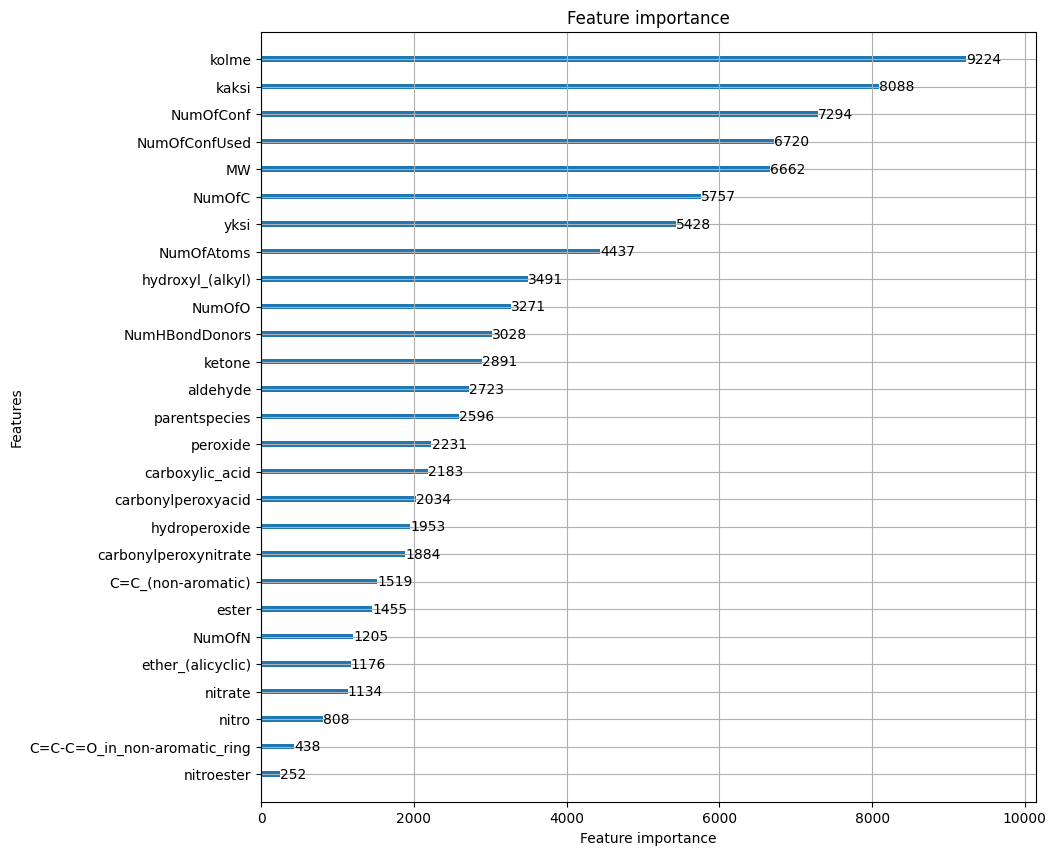

In [73]:
lgb.plot_importance(model, max_num_features=50, figsize=(10, 10))
plt.show()


In [1]:
sub["TARGET"] = preds
sub.to_csv("../Results/fri-yay4.csv", index=False)

NameError: name 'preds' is not defined